# VAR

In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [10, 7.5]

## United States Macroeconomic Data

In [3]:
var_data = pd.read_csv('var_data.csv', parse_dates=['date'], index_col='date')

print(var_data.shape)

(123, 8)


In [4]:
macro_data = sm.datasets.macrodata.load_pandas()

In [5]:
macro_data.data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


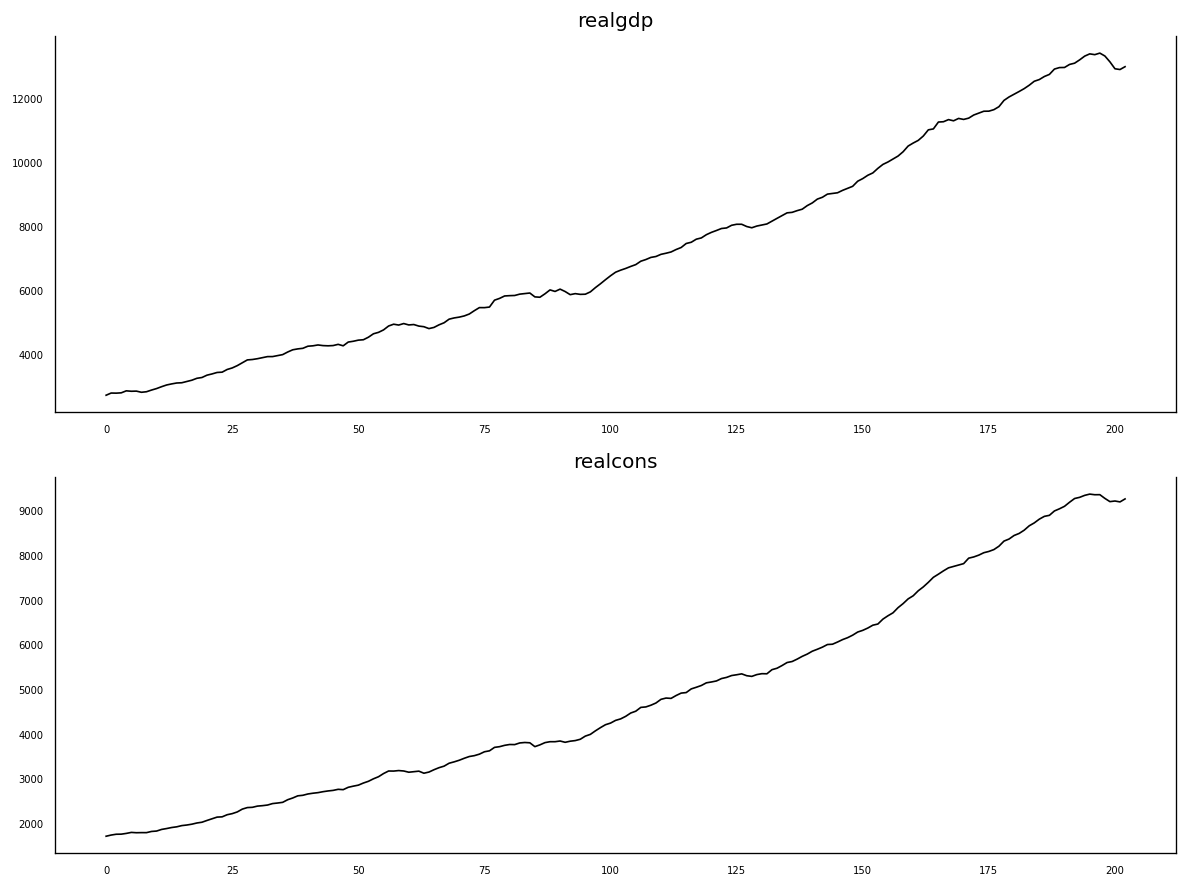

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=120)

ax1.plot(macro_data.data['realgdp'], color='black', linewidth=1)
ax1.set_title('realgdp')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize=6)

ax2.plot(macro_data.data['realcons'], color='black', linewidth=1)
ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize=6)

plt.tight_layout()

In [8]:
ad_fuller_result_1 = adfuller(macro_data.data['realgdp'])

print('realgdp')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n-----------------\n')

ad_fuller_result_2 = adfuller(macro_data.data['realcons'])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realgdp
ADF Statistic: 1.7504627967647128
p-value: 0.9982455372335032

-----------------

realcons
ADF Statistic: 1.549912338050963
p-value: 0.9976992503412904


In [9]:
ad_fuller_result_1 = adfuller(macro_data.data['realgdp'].diff()[1:])

print('realgdp')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n-----------------\n')

ad_fuller_result_2 = adfuller(macro_data.data['realcons'].diff()[1:])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realgdp
ADF Statistic: -6.305695561658106
p-value: 3.327882187668224e-08

-----------------

realcons
ADF Statistic: -4.204306080845246
p-value: 0.0006479282158627595


In [10]:
def optimize_VAR(endog):
    """
        Returns a dataframe with parameters and corresponding mse
        
        endog - observed time series
    """
    
    results = []
    
    for i in tqdm_notebook(range(15)):
        try:
            model = VARMAX(endog, order=(i, 0)).fit(disp=False)
        except:
            continue
            
        mse = model.mse
        results.append([i, mse])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'mse']
    
    result_df = result_df.sort_values(by='mse', ascending=True).reset_index(drop=True)
    
    return result_df

In [11]:
endog = macro_data.data[['realgdp', 'realcons']]

result_df = optimize_VAR(endog)
result_df

,p,mse
0,12,1.454861e+05
1,11,1.456712e+05
2,13,1.499392e+05
3,8,1.566051e+05
4,9,1.599435e+05
5,10,1.648905e+05
6,6,1.720855e+05
7,5,1.738301e+05
8,4,1.922231e+05
9,3,3.407586e+05


In [12]:
best_model = VARMAX(endog, order=(12,0))
res = best_model.fit(disp=False)
print(res.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realgdp', 'realcons']   No. Observations:                  203
Model:                             VAR(12)   Log Likelihood               -1983.718
                               + intercept   AIC                           4073.436
Date:                     Wed, 04 Nov 2020   BIC                           4249.036
Time:                             17:56:37   HQIC                          4144.477
Sample:                                  0                                         
                                     - 203                                         
Covariance Type:                       opg                                         
Ljung-Box (Q):                29.81, 36.59   Jarque-Bera (JB):          5.02, 10.29
Prob(Q):                        0.88, 0.62   Prob(JB):                   0.08, 0.01
Heteroskedasticity (H):         1.73, 2.56   Skew:                       0.3

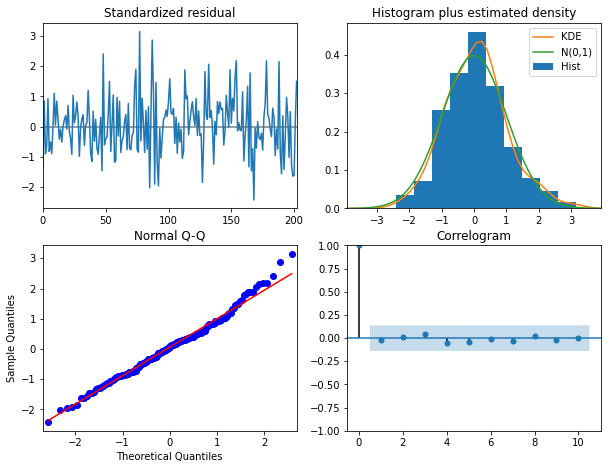

In [13]:
res.plot_diagnostics();

In [20]:
n_forecast = 3
predict = res.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))
predict.predicted_mean.tail(3)

,realgdp,realcons
204,13169.105365,9295.484235
205,13195.714669,9294.395863
206,13233.260539,9296.109447


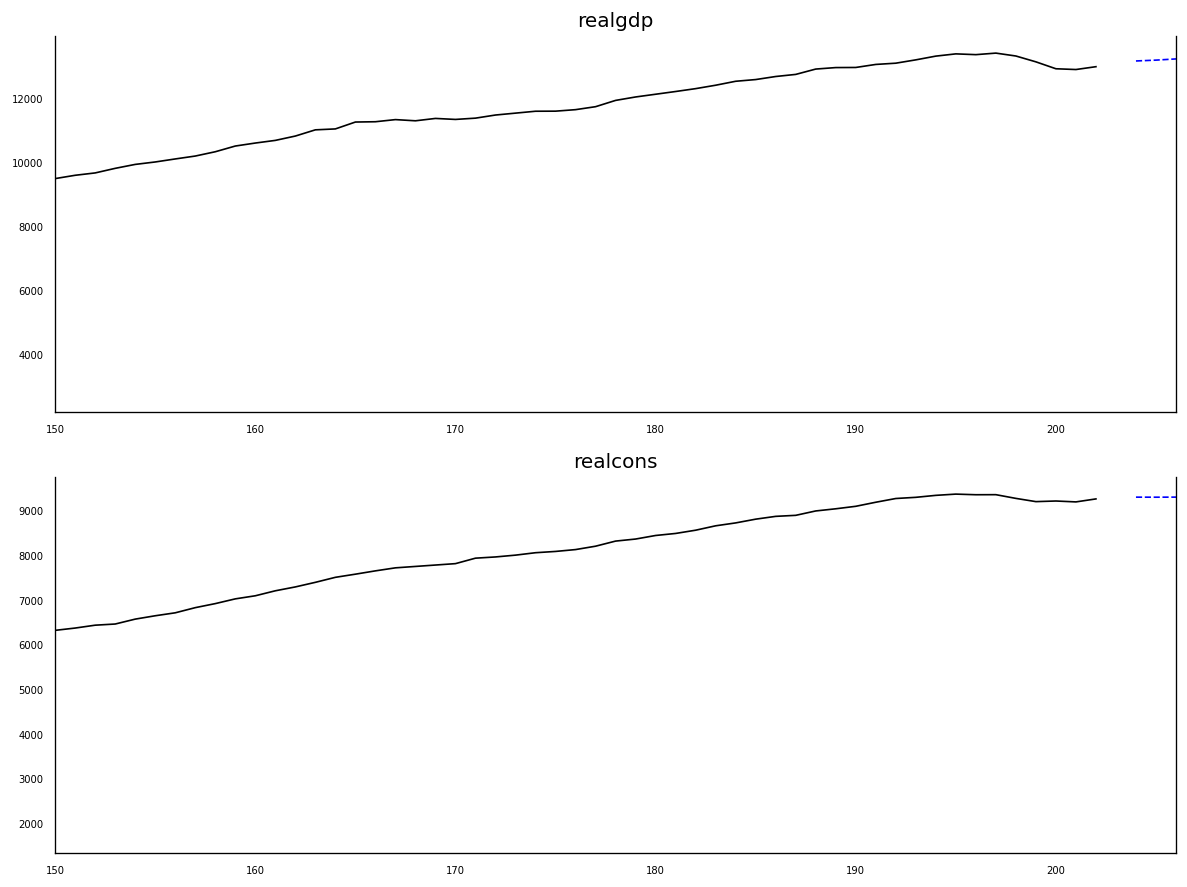

In [24]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=120)

ax1.plot(macro_data.data['realgdp'], color='black', linewidth=1)
ax1.plot(idx[-n_forecast:], predict.predicted_mean['realgdp'][-n_forecast:], color='blue', ls='--', linewidth=1)
ax1.set_title('realgdp')
ax1.xaxis.set_ticks_position('none')
ax1.set_xlim(150,206)
ax1.yaxis.set_ticks_position('none')
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize=6)

ax2.plot(macro_data.data['realcons'], color='black', linewidth=1)
ax2.plot(idx[-n_forecast:], predict.predicted_mean['realcons'][-n_forecast:], color='blue', ls='--', linewidth=1)
ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.set_xlim(150,206)
ax2.yaxis.set_ticks_position('none')
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize=6)

plt.tight_layout()

In [34]:
print('realcons causes realgdp?\n')
print('----------------')
granger_1 = grangercausalitytests(macro_data.data[['realgdp', 'realcons']].diff()[1:], [12])

print('\nrealgdp causes realcons?\n')
print('----------------')
granger_2 = grangercausalitytests(macro_data.data[['realcons', 'realgdp']].diff()[1:], [12])

realcons causes realgdp?

----------------

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=6.1144  , p=0.0000  , df_denom=165, df_num=12
ssr based chi2 test:   chi2=84.4900 , p=0.0000  , df=12
likelihood ratio test: chi2=69.8992 , p=0.0000  , df=12
parameter F test:         F=6.1144  , p=0.0000  , df_denom=165, df_num=12

realgdp causes realcons?

----------------

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=2.1147  , p=0.0185  , df_denom=165, df_num=12
ssr based chi2 test:   chi2=29.2218 , p=0.0037  , df=12
likelihood ratio test: chi2=27.1813 , p=0.0073  , df=12
parameter F test:         F=2.1147  , p=0.0185  , df_denom=165, df_num=12
